In [2]:
author="Jumabek Alikhanov"
date = 'Nov 19,2019'

In [3]:
#imports
import os
from os.path import join
import glob
import pandas as pd
import numpy as np
import time
%load_ext autoreload

In [4]:
# load data
#Please download dataset from http://205.174.165.80/CICDataset/CIC-IDS-2017/
dataroot = 'MachineLearningCVE/'

In [5]:
def read_data(dataroot,file_ending):
    if file_ending==None:
        print("please specify file ending pattern for glob")
        exit()
    print(join(dataroot,file_ending))
    filenames = [i for i in glob.glob(join(dataroot,file_ending))]
    combined_csv = pd.concat([pd.read_csv(f) for f in filenames],sort=False)
    return combined_csv

In [6]:
# read and preprocess data

data = read_data(dataroot,'*.pcap_ISCX.csv')

# there is white spaces in columns names e.g. ' Destination Port'
# So strip the whitespace from  column names
data = data.rename(columns=lambda x: x.strip())

df_label = data['Label']

# drop bad features (they tend to contain mostly NaN entries)
data = data.drop(columns=['Flow Packets/s','Flow Bytes/s','Label'])

#replace NaN entries with mean of the data 
data.fillna(data.mean(), inplace=True)
#convert to numeric
data = data.astype(float).apply(pd.to_numeric)

MachineLearningCVE/*.pcap_ISCX.csv


/home/juma/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/juma/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
# lets count if there is NaN values in our dataframe( AKA missing features)
data.isnull().sum().sum()

0

In [7]:
#Since the above data is imbalanced we do oversampling to balance data
def balance_data(X,y):
    unique,counts = np.unique(y,return_counts=True)
    mean_samples_per_class = int(round(np.mean(counts)))
    new_X = np.empty((0,X.shape[1]))
    new_y = np.empty((0),dtype=int)
    for i,c in enumerate(unique):
        temp_x = X[y==c]
        indices = np.random.choice(temp_x.shape[0],mean_samples_per_class)
        new_X = np.concatenate((new_X,temp_x[indices]),axis=0)
        temp_y = np.ones(mean_samples_per_class,dtype=int)*c
        new_y = np.concatenate((new_y,temp_y),axis=0)

    # in order to break class order in data we need shuffling
    indices = np.arange(new_y.shape[0])
    np.random.shuffle(indices)
    new_X =  new_X[indices,:]
    new_y = new_y[indices]
    return (new_X,new_y)


In [8]:
# chganges label from string to integer/index
def encode_label(Y_str):
    labels_d = make_value2index(np.unique(Y_str))
    Y = [labels_d[y_str] for y_str  in Y_str]
    Y = np.array(Y)
    return np.array(Y)

def make_value2index(attacks):
    #make dictionary
    attacks = sorted(attacks)
    d = {}
    counter=0
    for attack in attacks:
        d[attack] = counter
        counter+=1
    return d


In [9]:
# normalization
def normilize(data):
        data = data.astype(np.float32)
       
        eps = 1e-15

        mask = data==-1
        data[mask]=0
        mean_i = np.mean(data,axis=0)
        min_i = np.min(data,axis=0) #  to leave -1 (missing features) values as is and exclude in normilizing
        max_i = np.max(data,axis=0)

        r = max_i-min_i+eps
        data = (data-mean_i)/r  # zero centered 

        #deal with missing features -1
        data[mask] = 0
        
        nan_index = np.isnan(data)
        nan_data = data[nan_index]
        
        return data

In [10]:
data_np = data.values # convert to numpy array
X = data_np
X = normilize(X)
y = df_label.values
y = encode_label(y)
N = X.shape[0]
print(X.shape,y.shape)

(2830743, 76) (2830743,)


In [11]:

%autoreload 2
from shallows import LinearClassifier

def ensure_dir(dir_path):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

def getClassifier(args=None,runs_dir=None):
    if args is not None:
        (loss_function,optim,lr,reg,batch_size,input_dim,num_class) = args
    if runs_dir is not None:
        ensure_dir(runs_dir)
    
    num_epochs = 10
    
    clf = LinearClassifier(loss_function,input_dim,num_class,lr=lr,reg=reg,num_epochs=num_epochs,batch_size=batch_size,runs_dir=runs_dir)
    return clf


In [12]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_final_test, y_train, y__final_test = train_test_split(
    X, y, test_size=0.2, random_state=2)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=2)


In [13]:

#hyper-params
batch_size = 1024
optim = 'Adam'

input_dim = X_train.shape[1]
num_class = len(np.unique(y_train))

accuracies = {}
learning_rates = np.random.uniform(1e-4,1e-2,6)
regularizations = np.random.uniform(1e-7,1e-5,2)
best_model = None
best_acc = -1
num_layers = 3
loss_function = 'softmax'
for lr in learning_rates:
    for reg in regularizations:

        classifier_args = (loss_function,optim,lr,reg,batch_size,input_dim,num_class)
        config =  '{}/1st_run/optim_{}_lr_{}_reg_{}_bs_{}'.format(loss_function,num_layers,optim,lr,reg,batch_size)
        runs_dir = join(dataroot,'runs',config)
        
        X_train = X_train.astype(float)
        y_train = y_train.astype(int)
        p = np.random.permutation(len(y_train))
        X_train = X_train[p]
        y_train = y_train[p]
        X_train,y_train = balance_data(X_train,y_train)

        tick = time.time()
        clf = getClassifier(classifier_args,runs_dir)
        
        clf.fit(X_train,y_train,verbose=False)
        pred = clf.predict(X_val)
        
        acc = metrics.balanced_accuracy_score(y_val,pred)
        if acc >best_acc:
            best_model = clf
            best_acc = acc
        accuracies[(lr,reg)]=acc
        tock = time.time()
        print("Model is trained in {0:.0f} sec ".format(tock-tick))

Model is created


AttributeError: 'float' object has no attribute '0f'

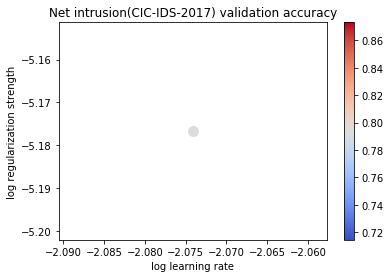

In [17]:
# Visualize the cross-validation results
import math
import matplotlib.pyplot as plt
results = accuracies
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]


# plot validation accuracy
marker_size=100
colors = [results[x] for x in results] # default size of markers is 20

plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('Net intrusion(CIC-IDS-2017) validation accuracy')
plt.savefig(join(dataroot,'runs',loss_function,'1st_run.png'))
plt.show()